# Kelompok 4 - Phishing Website Detection

| Nama | NRP |
|------|-----|
|   Pramuditya Faiz Ardiansyah   |    5025231108 |
|   Muhammad Azhar Aziz |   5025231131  |
|   Daniel Yunus Yumame    |  5025231305  |



> Dataset : [phiUSIIL Phising URL](https://kaggle.com/datasets/0b97ba2b6b21911d0a9c0c56a2e254f2327998cb9b30c7a7156a9eb8a3e320b5)

## Import Library & Download Data

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
# from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
import gdown

file_id = '1OV_ae6dnggvw2TJOFq4zTyeWaAOAXs2V'
output_filename = 'train.csv'
gdown.download(f'https://drive.google.com/uc?id={file_id}', output_filename, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1OV_ae6dnggvw2TJOFq4zTyeWaAOAXs2V
To: /content/train.csv
100%|██████████| 30.1M/30.1M [00:00<00:00, 38.3MB/s]


'train.csv'

## Load Data & General Information

In [ ]:
df = pd.read_csv('train.csv')

print(f"Dataset shape: {df.shape}")
print(f"Features: {df.shape[1] - 1}")
print(f"Samples: {df.shape[0]}")

Dataset shape: (99935, 56)
Features: 55
Samples: 99935


In [ ]:
df.info()

print(f"\nMissing values:")
missing_values = df.isnull().sum()

if missing_values.sum() > 0:
    print(missing_values[missing_values > 0].sort_values(ascending=False))
else:
    print("No missing values.")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99935 entries, 0 to 99934
Data columns (total 56 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   FILENAME                    94899 non-null  object 
 1   URL                         99935 non-null  object 
 2   URLLength                   99935 non-null  int64  
 3   Domain                      99935 non-null  object 
 4   DomainLength                99935 non-null  int64  
 5   IsDomainIP                  99935 non-null  int64  
 6   TLD                         99935 non-null  object 
 7   URLSimilarityIndex          99935 non-null  float64
 8   CharContinuationRate        94999 non-null  float64
 9   TLDLegitimateProb           99935 non-null  float64
 10  URLCharProb                 99935 non-null  float64
 11  TLDLength                   99935 non-null  float64
 12  NoOfSubDomain               99935 non-null  int64  
 13  HasObfuscation              999

## Target & Data Analysis

- Class imbalance ratio
- Data quality issues
- Outlier distribution
- Feature Correlation
- Summary

### Class Imbalance Ratio

Label distribution:
label
0    90850
1     9085
Name: count, dtype: int64

Label proportions:
label
0    0.909091
1    0.090909
Name: proportion, dtype: float64


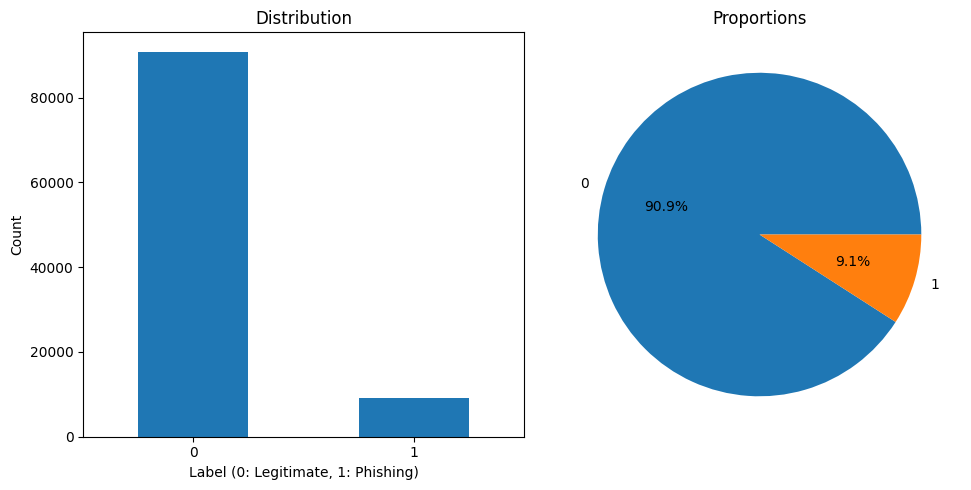


Class imbalance ratio: 0.100


In [ ]:
target_counts = df['label'].value_counts()
print(f"Label distribution:")
print(target_counts)
print(f"\nLabel proportions:")
print(df['label'].value_counts(normalize=True))

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
df['label'].value_counts().plot(kind='bar')
plt.title('Distribution')
plt.xlabel('Label (0: Legitimate, 1: Phishing)')
plt.ylabel('Count')
plt.xticks(rotation=0)

plt.subplot(1, 2, 2)
df['label'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Proportions')
plt.ylabel('')

plt.tight_layout()
plt.show()

class_ratio = target_counts.min() / target_counts.max()
print(f"\nClass imbalance ratio: {class_ratio:.3f}")


### Data Quality Issues

- Numerical / categorical features
- Check for constant features
- Check for duplicate columns

In [ ]:
numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = df.select_dtypes(include=['object']).columns.tolist()

if 'label' in numerical_features:
    numerical_features.remove('label')

print(f"Numerical features ({len(numerical_features)}): {numerical_features[:10]}{'...' if len(numerical_features) > 10 else ''}")
print(f"Categorical features ({len(categorical_features)}): {categorical_features}")

constant_features = []
for col in numerical_features:
    if df[col].nunique() <= 1:
        constant_features.append(col)

if constant_features:
    print(f"\nConstant features: True ({constant_features})")
else:
    print("\nConstant features: False")

duplicate_cols = []
for i, col1 in enumerate(numerical_features):
    for col2 in numerical_features[i+1:]:
        if df[col1].equals(df[col2]):
            duplicate_cols.append((col1, col2))

if duplicate_cols:
    print(f"\nDuplicate columns: True ({duplicate_cols})")
else:
    print("\nDuplicate columns: False")

# high uniqueness feature
threshold = 0.8
total_rows = len(df)

high_unique_features = []
for col in df.columns:
    if col != 'label':
        n_unique = df[col].nunique()
        unique_ratio = n_unique / total_rows
        if unique_ratio > threshold:
            high_unique_features.append((col, f"{unique_ratio:.2%}"))

if high_unique_features:
    print("\nFeatures with high uniqueness (>80% unique values):")
    for feature, ratio in high_unique_features:
        print(f"- {feature}: {ratio} unique values")
else:
    print("\nNo features with high uniqueness ratio found.")

Numerical features (50): ['URLLength', 'DomainLength', 'IsDomainIP', 'URLSimilarityIndex', 'CharContinuationRate', 'TLDLegitimateProb', 'URLCharProb', 'TLDLength', 'NoOfSubDomain', 'HasObfuscation']...
Categorical features (5): ['FILENAME', 'URL', 'Domain', 'TLD', 'Title']

Constant features: False

Duplicate columns: False

Features with high uniqueness (>80% unique values):
- FILENAME: 94.96% unique values
- URL: 99.64% unique values
- Domain: 86.37% unique values
- URLCharProb: 95.01% unique values


### Outlier Distribution

Menggunakan metode IQR untuk menentukan outlier.

Reference : [Interquartile Range to Detect Outliers in Data](https://www.geeksforgeeks.org/interquartile-range-to-detect-outliers-in-data/)

In [ ]:
outlier_features = []
outlier_counts = {}

for feature in numerical_features:
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)][feature]
    if len(outliers) > 0:
        outlier_features.append(feature)
        outlier_counts[feature] = len(outliers)

if outlier_features:
    print(f"Features with outliers: {len(outlier_features)}")
    print(f"\nTop 10 Outlier:")
    sorted_outliers = sorted(outlier_counts.items(), key=lambda x: x[1], reverse=True)[:10]
    for feature, count in sorted_outliers:
        percentage = (count / len(df)) * 100
        print(f"- {feature}: {count} ({percentage:.1f}%)")
else:
    print("No outliers.")

Features with outliers: 43

Top 10 Outlier:
- NoOfSubDomain: 34985 (35.0%)
- DomainTitleMatchScore: 24799 (24.8%)
- LargestLineLength: 20440 (20.5%)
- NoOfImage: 18203 (18.2%)
- NoOfJS: 15690 (15.7%)
- NoOfURLRedirect: 14886 (14.9%)
- HasSubmitButton: 13637 (13.6%)
- HasHiddenFields: 13197 (13.2%)
- HasFavicon: 13113 (13.1%)
- LineOfCode: 12865 (12.9%)


<Figure size 2000x1200 with 0 Axes>

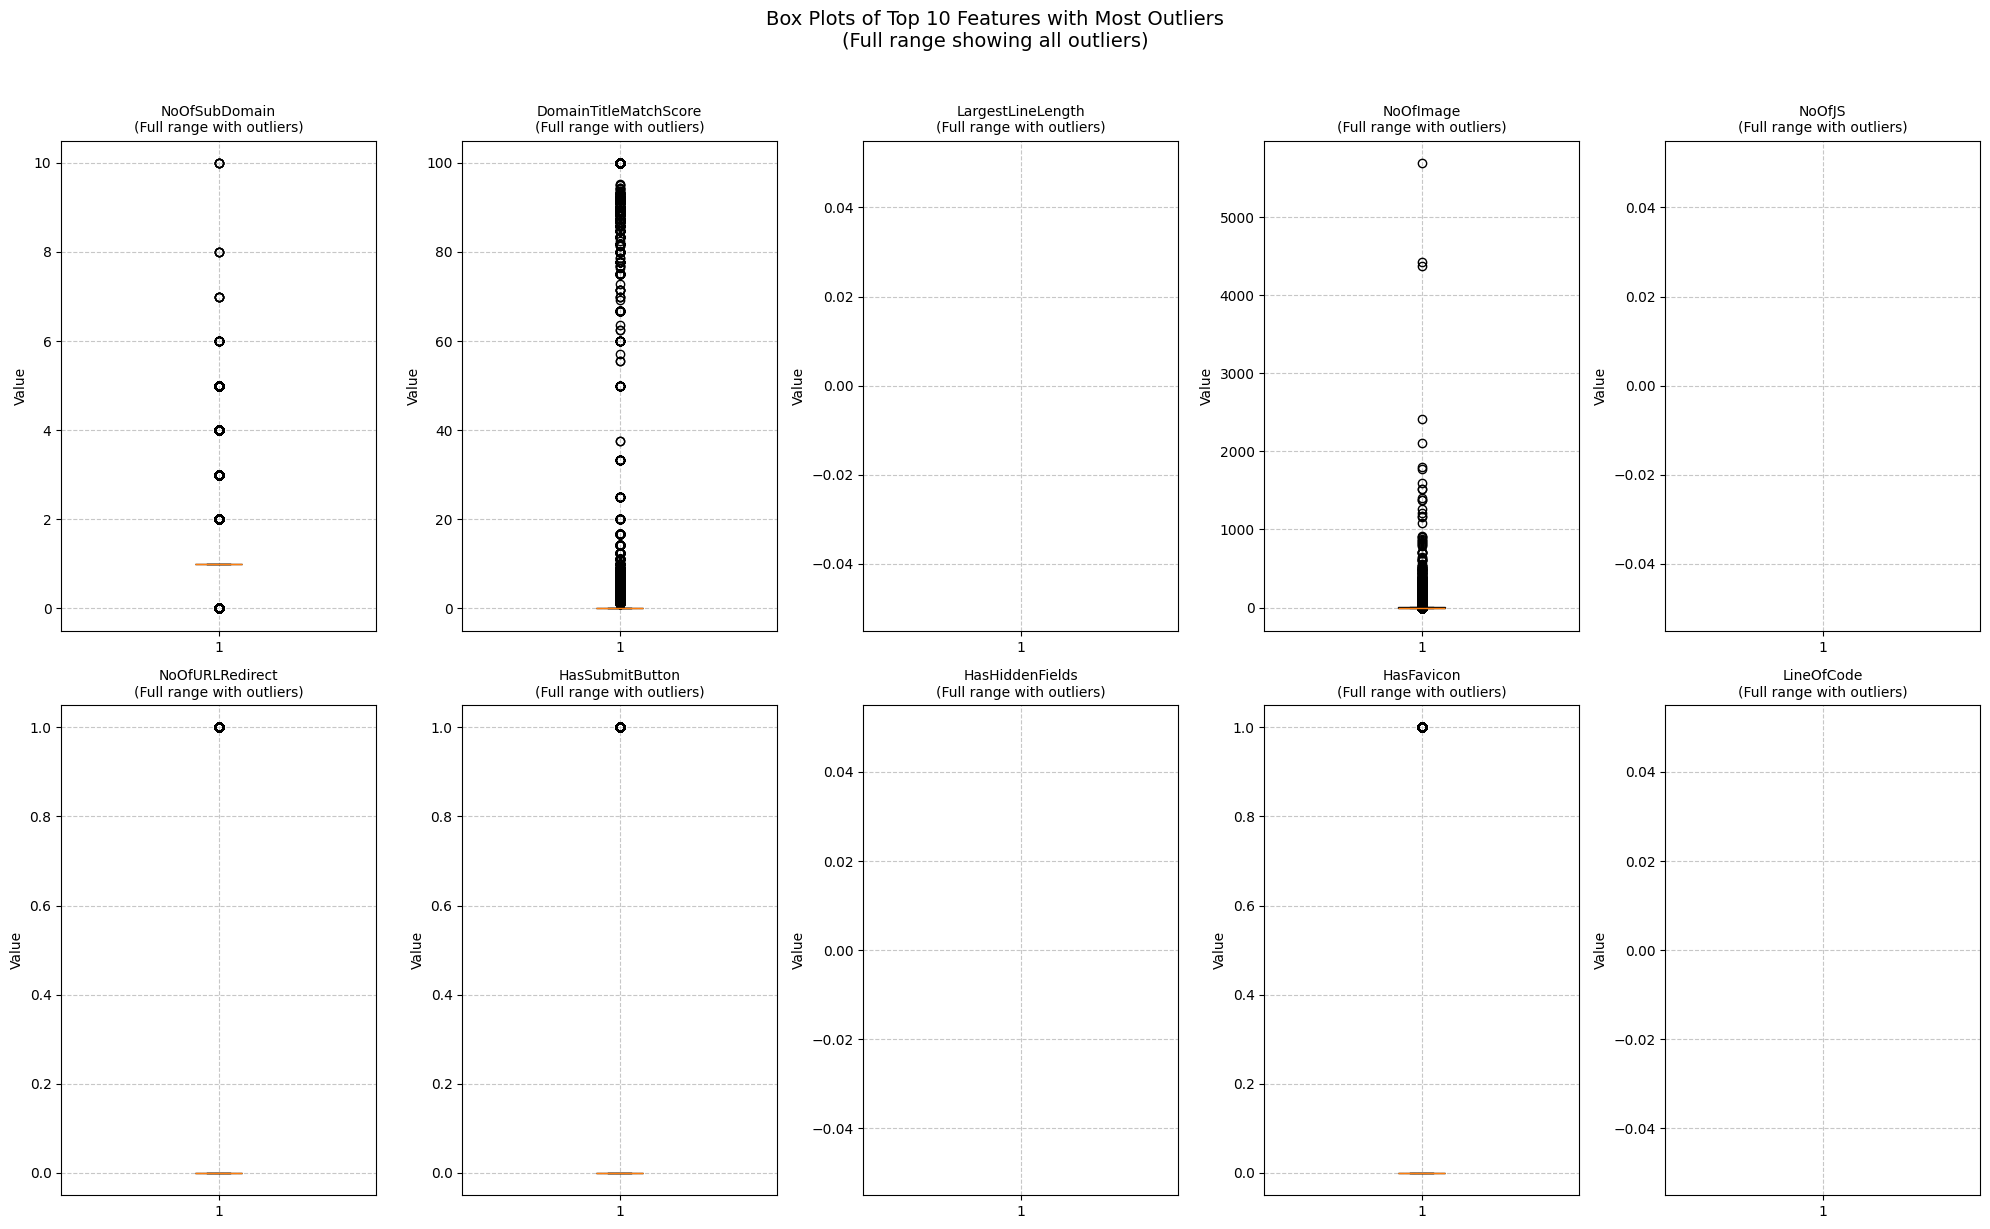

In [ ]:
# box plot 10 fitur dengan outlier terbanyak
plt.figure(figsize=(20, 12))

sorted_outliers = sorted(outlier_counts.items(), key=lambda x: x[1], reverse=True)[:10]
top_10_features = [feature for feature, _ in sorted_outliers]

plt.figure(figsize=(20, 12))

for idx, feature in enumerate(top_10_features, 1):
    plt.subplot(2, 5, idx)

    box_plot = plt.boxplot(df[feature], patch_artist=True)
    box_plot['boxes'][0].set_facecolor('lightblue')

    plt.title(f'{feature}\n(Full range with outliers)', fontsize=10)
    plt.ylabel('Value')
    plt.grid(True, linestyle='--', alpha=0.7)

plt.suptitle('Box Plots of Top 10 Features with Most Outliers\n(Full range showing all outliers)', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()


### Feature Correlation

- Mencari feature dengan correlation terbesar terhadap target (label)


Correlation Matrix:


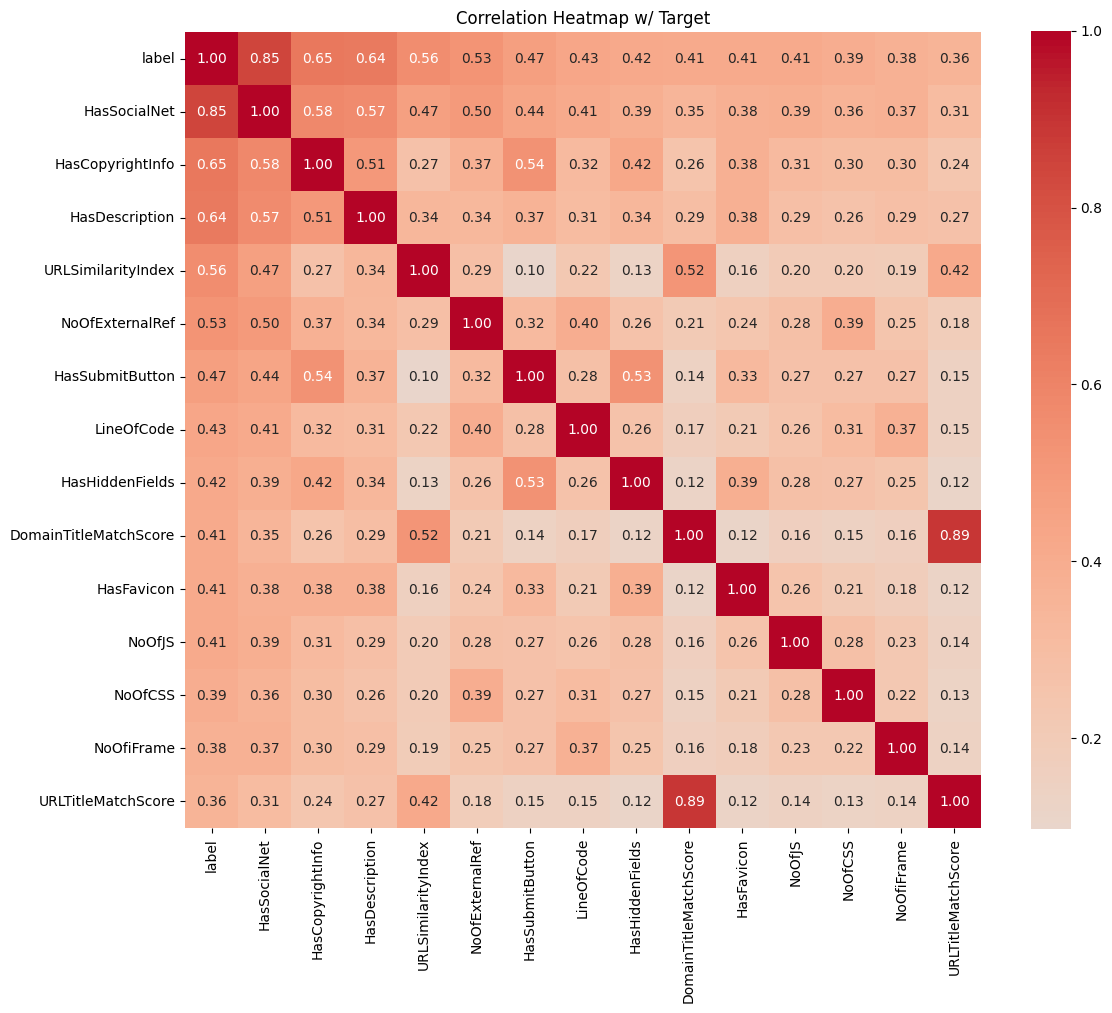


Features correlated w/ target:
- HasSocialNet: 0.850
- HasCopyrightInfo: 0.650
- HasDescription: 0.640
- URLSimilarityIndex: 0.559
- NoOfExternalRef: 0.528
- HasSubmitButton: 0.475
- LineOfCode: 0.430
- HasHiddenFields: 0.415
- DomainTitleMatchScore: 0.411
- HasFavicon: 0.411
- NoOfJS: 0.410
- NoOfCSS: 0.394
- NoOfiFrame: 0.375
- URLTitleMatchScore: 0.356
- Robots: 0.341
- NoOfImage: 0.329
- NoOfSelfRef: 0.321
- IsResponsive: 0.317
- Pay: 0.312
- IsHTTPS: 0.293
- SpacialCharRatioInURL: 0.282
- URLCharProb: 0.247
- CharContinuationRate: 0.243
- HasTitle: 0.203
- HasExternalFormSubmit: 0.198
- LetterRatioInURL: 0.192
- DegitRatioInURL: 0.190
- NoOfEmptyRef: 0.170
- NoOfOtherSpecialCharsInURL: 0.165
- Bank: 0.148
- DomainLength: 0.127
- NoOfPopup: 0.112
- NoOfLettersInURL: 0.105
- HasPasswordField: 0.099
- URLLength: 0.097
- Crypto: 0.095
- NoOfDegitsInURL: 0.078
- NoOfQMarkInURL: 0.071
- TLDLegitimateProb: 0.053
- TLDLength: 0.042
- NoOfSelfRedirect: 0.035
- NoOfEqualsInURL: 0.034
- IsD

In [ ]:
correlation_matrix = df[numerical_features + ['label']].corr()

print("\nCorrelation Matrix:")

target_correlations = correlation_matrix['label'].abs().sort_values(ascending=False)
top_features = target_correlations.head(15).index.tolist()

plt.figure(figsize=(12, 10))
sns.heatmap(df[top_features].corr(), annot=True, cmap='coolwarm', center=0,
            fmt='.2f', square=True)
plt.title('Correlation Heatmap w/ Target')
plt.tight_layout()
plt.show()

print(f"\nFeatures correlated w/ target:")
for feature in target_correlations.index[1:]:
    print(f"- {feature}: {target_correlations[feature]:.3f}")

In [ ]:
print("Summary:")
preprocessing_steps = []

if constant_features:
    print(f"- Constant features ({len(constant_features)}): True")
else:
    print("- Constant features: False")

if duplicate_cols:
    print(f"- Duplicate columns ({len(duplicate_cols)}): True")
else:
    print("- Duplicate columns: False")

if high_unique_features:
    print(f"- High uniqueness features ({len(high_unique_features)}): True")
else:
    print("- High uniqueness features: False")

if categorical_features:
    print(f"- Categorical features ({len(categorical_features)}): True")
else:
    print("- Categorical features: False")

if numerical_features:
    print(f"- Numerical features ({len(numerical_features)}): True")
else:
    print("- Numerical features: False")

if outlier_features:
    print(f"- Outliers ({len(outlier_features)}): True")
else:
    print("- Outliers: False")

if class_ratio < 0.8:
    print("- Class imbalance ratio < 0.8")
else:
    print("- Class imbalance ratio >= 0.8")


Summary:
- Constant features: False
- Duplicate columns: False
- High uniqueness features (4): True
- Categorical features (5): True
- Numerical features (50): True
- Outliers (43): True
- Class imbalance ratio < 0.8


## Data Preprocessing / Feature Engineering

Berdasarkan hasil analisis sebelumnya, ada beberapa hal yang perlu dilakukan dalam tahap preprocessing:

- Fix missing value
- Encode categorical features
- Create new feature (URL Based, Security Based, Suspicious Activity Score)
- MinMax scaling
- Class balancing (SMOTE)

In [ ]:
df_processed = df.copy()

X = df_processed.drop(['label'], axis=1)
y = df_processed['label']

X = X.select_dtypes(include=[np.number])

### Encode Categorical Features

In [ ]:
if categorical_features:
    print(f"Encoding {len(categorical_features)} categorical features...")
    le = LabelEncoder()
    for col in categorical_features:
        if col in df_processed.columns:
            df_processed[col] = le.fit_transform(df_processed[col].astype(str))
    print(f"Categorical features encoded: {categorical_features}")


Encoding 5 categorical features...
Categorical features encoded: ['FILENAME', 'URL', 'Domain', 'TLD', 'Title']


### Log Transformation

In [ ]:
# log transformation outlier_features
for col in outlier_features:
    if df_processed[col].nunique() > 2:
        if (df_processed[col] >= 0).all():
            df_processed[col] = df_processed[col].replace([np.inf, -np.inf], np.nan)
            df_processed[col] = np.log1p(df_processed[col])  # log1p to handle zeros

X = df_processed.drop(['label'], axis=1)

### Create New Features (URL Based, Security Based, Suspicious Activity Score)

In [ ]:
if 'URLLength' in X.columns and 'DomainLength' in X.columns:
    X['URLToDomainRatio'] = X['URLLength'] / (X['DomainLength'] + 1)

if 'NoOfSubDomain' in X.columns and 'DomainLength' in X.columns:
    X['SubdomainDensity'] = X['NoOfSubDomain'] / (X['DomainLength'] + 1)

security_features = ['IsHTTPS', 'HasFavicon', 'IsResponsive']
existing_security = [f for f in security_features if f in X.columns]
if len(existing_security) > 1:
    X['SecurityScore'] = X[existing_security].sum(axis=1)

suspicious_features = ['HasObfuscation', 'NoOfPopup', 'NoOfiFrame', 'HasHiddenFields']
existing_suspicious = [f for f in suspicious_features if f in X.columns]
if len(existing_suspicious) > 1:
    X['SuspiciousScore'] = X[existing_suspicious].sum(axis=1)

print(f"Total features in X after engineering: {X.shape[1]} features")


Total features in X after engineering: 59 features


### Fix Missing Value + MinMax Scalling

In [ ]:
imputer = SimpleImputer(strategy='mean')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

print(f"Feature set shape after preprocessing: {X.shape}")

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)


Feature set shape after preprocessing: (99935, 59)


### Class Balancing

Menggunakan SMOTE untuk mem-"balance"kan train set. Kenapa SMOTE bagus untuk use case ini:
- Kebanyakan features merupakan numerical
- Cenderung website phising memiliki pattern yang sama

Reference : [SMOTE for Imbalanced Classification with Python](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=69, stratify=y
)

smote = SMOTE(random_state=69, k_neighbors=5)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print(f"Training set after SMOTE: {X_train_balanced.shape}")
print(f"Balanced class distribution:")
print(pd.Series(y_train_balanced).value_counts())
print(f"New class ratio: {pd.Series(y_train_balanced).value_counts().min() / pd.Series(y_train_balanced).value_counts().max():.3f}")


Training set after SMOTE: (145360, 59)
Balanced class distribution:
label
0    72680
1    72680
Name: count, dtype: int64
New class ratio: 1.000


## Training
Rencana Model:

- Random Forest
- Gradient Boosting/Boosting lain
- SVM
- KNN
- Naive Bayes
- Decision Tree

In [ ]:
# !pip install optuna

# !pip install optuna-integration[sklearn]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 kB 2.0 MB/s eta 0:00:00


In [ ]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier-
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
import xgboost as xgb
import lightgbm as lgb
import optuna
from optuna.integration import OptunaSearchCV

# print(f"Training data NaN: {np.isnan(X_train_balanced).any()}")
# print(f"Test data NaN: {np.isnan(X_test).any()}")
# print(f"Training labels NaN: {pd.isna(y_train_balanced).any()}")
# print(f"Test labels NaN: {pd.isna(y_test).any()}")

# if pd.DataFrame(X_train_balanced).isna().any().any():
#     X_train_balanced = np.nan_to_num(X_train_balanced, nan=0.0)

# if pd.DataFrame(X_test).isna().any().any():
#     X_test = np.nan_to_num(X_test, nan=0.0)

RANDOM_STATE = 69

### Random Forest

In [ ]:
print("Training Random Forest...")

rf_pipeline = Pipeline(steps=[
    ('classifier', RandomForestClassifier(random_state=RANDOM_STATE))
])

rf_param_distributions = {
    'classifier__n_estimators': optuna.distributions.IntDistribution(50, 500),
    'classifier__max_depth': optuna.distributions.IntDistribution(3, 30),
    'classifier__min_samples_split': optuna.distributions.IntDistribution(2, 20),
    'classifier__min_samples_leaf': optuna.distributions.IntDistribution(1, 10),
    'classifier__max_features': optuna.distributions.CategoricalDistribution(['sqrt', 'log2', None])
}

rf_optuna = OptunaSearchCV(
    rf_pipeline,
    rf_param_distributions,
    cv=3,
    n_trials=50,
    scoring='accuracy',
    n_jobs=-1,
    random_state=RANDOM_STATE,
    verbose=1
)

rf_optuna.fit(X_train_balanced, y_train_balanced)

print(f"Best RF parameters: {rf_optuna.best_params_}")
print(f"Best RF cross-validation score: {rf_optuna.best_score_:.4f}")

rf_preds = rf_optuna.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_preds)
rf_roc_auc = roc_auc_score(y_test, rf_optuna.predict_proba(X_test)[:, 1])

print(f"RF Test accuracy: {rf_accuracy:.4f}")
print(f"RF Test ROC AUC: {rf_roc_auc:.4f}")

best_rf = rf_optuna.best_estimator_


Training Random Forest...


<ipython-input-40-7d100ab0d065>:15: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  rf_optuna = OptunaSearchCV(
[I 2025-06-10 16:19:47,516] A new study created in memory with name: no-name-860c6172-f307-478b-8ee1-885dcb761f5c
INFO:optuna_integration.sklearn.sklearn:Searching the best hyperparameters using 145360 samples...
[I 2025-06-10 16:23:54,189] Trial 1 finished with value: 0.999979361443048 and parameters: {'classifier__n_estimators': 257, 'classifier__max_depth': 25, 'classifier__min_samples_split': 14, 'classifier__min_samples_leaf': 5, 'classifier__max_features': 'sqrt'}. Best is trial 1 with value: 0.999979361443048.
[I 2025-06-10 16:31:23,911] Trial 2 finished with value: 0.9999931204810159 and parameters: {'classifier__n_estimators': 173, 'classifier__max_depth': 28, 'classifier__min_samples_split': 6, 'classifier__min_samples_leaf': 5, 'classifier__max_features': None}. Best is trial 2 with value: 0.99

Best RF parameters: {'classifier__n_estimators': 173, 'classifier__max_depth': 28, 'classifier__min_samples_split': 6, 'classifier__min_samples_leaf': 5, 'classifier__max_features': None}
Best RF cross-validation score: 1.0000
RF Test accuracy: 0.9999
RF Test ROC AUC: 1.0000


### Gradient Boosting

In [ ]:
print("\nTraining Gradient Boosting...")

gb_pipeline = Pipeline(steps=[
    ('classifier', GradientBoostingClassifier(random_state=RANDOM_STATE))
])

gb_param_distributions = {
    'classifier__n_estimators': optuna.distributions.IntDistribution(50, 500),
    'classifier__learning_rate': optuna.distributions.FloatDistribution(0.01, 0.3),
    'classifier__max_depth': optuna.distributions.IntDistribution(2, 15),
    'classifier__subsample': optuna.distributions.FloatDistribution(0.5, 1.0),
    'classifier__min_samples_split': optuna.distributions.IntDistribution(2, 20),
    'classifier__min_samples_leaf': optuna.distributions.IntDistribution(1, 10),
    'classifier__max_features': optuna.distributions.CategoricalDistribution(['sqrt', 'log2'])
}

gb_optuna = OptunaSearchCV(
    gb_pipeline,
    gb_param_distributions,
    cv=3,
    n_trials=50,
    scoring='accuracy',
    n_jobs=-1,
    random_state=RANDOM_STATE,
    verbose=1
)

gb_optuna.fit(X_train_balanced, y_train_balanced)

print(f"Best GB parameters: {gb_optuna.best_params_}")
print(f"Best GB cross-validation score: {gb_optuna.best_score_:.4f}")

gb_preds = gb_optuna.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_preds)
gb_roc_auc = roc_auc_score(y_test, gb_optuna.predict_proba(X_test)[:, 1])

print(f"GB Test accuracy: {gb_accuracy:.4f}")
print(f"GB Test ROC AUC: {gb_roc_auc:.4f}")

best_gb = gb_optuna.best_estimator_

<ipython-input-26-3061756057>:17: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  gb_optuna = OptunaSearchCV(
[I 2025-06-11 00:33:43,484] A new study created in memory with name: no-name-58831b27-008a-46de-866d-8eb491b30737
INFO:optuna_integration.sklearn.sklearn:Searching the best hyperparameters using 145360 samples...



Training Gradient Boosting...


[I 2025-06-11 00:35:45,668] Trial 0 finished with value: 0.9999931204810159 and parameters: {'classifier__n_estimators': 268, 'classifier__learning_rate': 0.27199459173102947, 'classifier__max_depth': 9, 'classifier__subsample': 0.6275485009231223, 'classifier__min_samples_split': 5, 'classifier__min_samples_leaf': 4, 'classifier__max_features': 'log2'}. Best is trial 0 with value: 0.9999931204810159.
[I 2025-06-11 00:37:45,514] Trial 1 finished with value: 0.9999931204810159 and parameters: {'classifier__n_estimators': 219, 'classifier__learning_rate': 0.10572315288148436, 'classifier__max_depth': 9, 'classifier__subsample': 0.6398521264948374, 'classifier__min_samples_split': 13, 'classifier__min_samples_leaf': 10, 'classifier__max_features': 'log2'}. Best is trial 0 with value: 0.9999931204810159.
[I 2025-06-11 00:38:24,853] Trial 2 finished with value: 1.0 and parameters: {'classifier__n_estimators': 375, 'classifier__learning_rate': 0.24515230812370814, 'classifier__max_depth': 9,

Best GB parameters: {'classifier__n_estimators': 375, 'classifier__learning_rate': 0.24515230812370814, 'classifier__max_depth': 9, 'classifier__subsample': 0.8547711213404385, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 4, 'classifier__max_features': 'sqrt'}
Best GB cross-validation score: 1.0000
GB Test accuracy: 1.0000
GB Test ROC AUC: 1.0000


### XGBoost

In [ ]:
print("\nTraining XGBoost...")

xgb_pipeline = Pipeline(steps=[
    ('classifier', xgb.XGBClassifier(
        random_state=RANDOM_STATE,
        eval_metric='logloss',
        use_label_encoder=False
    ))
])

xgb_param_distributions = {
    'classifier__n_estimators': optuna.distributions.IntDistribution(50, 500),
    'classifier__learning_rate': optuna.distributions.FloatDistribution(0.01, 0.3),
    'classifier__max_depth': optuna.distributions.IntDistribution(2, 15),
    'classifier__colsample_bytree': optuna.distributions.FloatDistribution(0.5, 1.0),
    'classifier__subsample': optuna.distributions.FloatDistribution(0.5, 1.0),
    'classifier__gamma': optuna.distributions.FloatDistribution(0, 5),
    'classifier__min_child_weight': optuna.distributions.IntDistribution(1, 10),
    'classifier__reg_alpha': optuna.distributions.FloatDistribution(0, 2),
    'classifier__reg_lambda': optuna.distributions.FloatDistribution(0, 2)
}

xgb_optuna = OptunaSearchCV(
    xgb_pipeline,
    xgb_param_distributions,
    cv=3,
    n_trials=50,
    scoring='accuracy',
    n_jobs=-1,
    random_state=RANDOM_STATE,
    verbose=1
)

xgb_optuna.fit(X_train_balanced, y_train_balanced)

print(f"Best XGB parameters: {xgb_optuna.best_params_}")
print(f"Best XGB cross-validation score: {xgb_optuna.best_score_:.4f}")

xgb_preds = xgb_optuna.predict(X_test)
xgb_accuracy = accuracy_score(y_test, xgb_preds)
xgb_roc_auc = roc_auc_score(y_test, xgb_optuna.predict_proba(X_test)[:, 1])

print(f"XGB Test accuracy: {xgb_accuracy:.4f}")
print(f"XGB Test ROC AUC: {xgb_roc_auc:.4f}")

best_xgb = xgb_optuna.best_estimator_

<ipython-input-42-46c6aedef22a>:23: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  xgb_optuna = OptunaSearchCV(



Training XGBoost...


[I 2025-06-10 20:43:57,711] A new study created in memory with name: no-name-f4dc9023-c5f1-4c41-97da-30fee35f8cfd
INFO:optuna_integration.sklearn.sklearn:Searching the best hyperparameters using 145360 samples...
[I 2025-06-10 20:44:28,173] Trial 1 finished with value: 0.9999931204810159 and parameters: {'classifier__n_estimators': 326, 'classifier__learning_rate': 0.04724004071979881, 'classifier__max_depth': 15, 'classifier__colsample_bytree': 0.8178644946520965, 'classifier__subsample': 0.7870799241019129, 'classifier__gamma': 3.3767265417140195, 'classifier__min_child_weight': 1, 'classifier__reg_alpha': 0.03938494826462802, 'classifier__reg_lambda': 1.565155422763563}. Best is trial 1 with value: 0.9999931204810159.
[I 2025-06-10 20:44:36,773] Trial 0 finished with value: 0.9999656025470602 and parameters: {'classifier__n_estimators': 456, 'classifier__learning_rate': 0.10343168021045646, 'classifier__max_depth': 4, 'classifier__colsample_bytree': 0.6512874083726388, 'classifier__

Best XGB parameters: {'classifier__n_estimators': 326, 'classifier__learning_rate': 0.04724004071979881, 'classifier__max_depth': 15, 'classifier__colsample_bytree': 0.8178644946520965, 'classifier__subsample': 0.7870799241019129, 'classifier__gamma': 3.3767265417140195, 'classifier__min_child_weight': 1, 'classifier__reg_alpha': 0.03938494826462802, 'classifier__reg_lambda': 1.565155422763563}
Best XGB cross-validation score: 1.0000
XGB Test accuracy: 0.9999
XGB Test ROC AUC: 1.0000


### SVM

In [ ]:
print("\nTraining SVM...")

svm_pipeline = Pipeline(steps=[
    ('classifier', SVC(random_state=RANDOM_STATE, probability=True))
])

svm_param_distributions = {
    'classifier__C': optuna.distributions.FloatDistribution(0.1, 1000, log=True),
    'classifier__gamma': optuna.distributions.FloatDistribution(1e-6, 1e2, log=True),
    'classifier__kernel': optuna.distributions.CategoricalDistribution(['rbf', 'linear', 'poly']),
    'classifier__degree': optuna.distributions.IntDistribution(2, 5),  # Only used for poly kernel
    'classifier__coef0': optuna.distributions.FloatDistribution(0, 10)  # For poly/sigmoid kernels
}

svm_optuna = OptunaSearchCV(
    svm_pipeline,
    svm_param_distributions,
    cv=3,
    n_trials=30,  # Reduced for SVM as it's computationally expensive
    scoring='accuracy',
    n_jobs=-1,
    random_state=RANDOM_STATE,
    verbose=1
)

svm_optuna.fit(X_train_balanced, y_train_balanced)
svm_preds = svm_optuna.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_preds)
svm_roc_auc = roc_auc_score(y_test, svm_optuna.predict_proba(X_test)[:, 1])

print(f"SVM Test accuracy: {svm_accuracy:.4f}")
print(f"SVM Test ROC AUC: {svm_roc_auc:.4f}")

<ipython-input-43-c0d0157be52a>:15: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  svm_optuna = OptunaSearchCV(
[I 2025-06-10 20:55:24,729] A new study created in memory with name: no-name-2090aa08-865d-4fac-b5d7-89665694b22d
INFO:optuna_integration.sklearn.sklearn:Searching the best hyperparameters using 145360 samples...



Training SVM...


[I 2025-06-10 20:56:29,203] Trial 0 finished with value: 0.9998968082091024 and parameters: {'classifier__C': 128.6425193624313, 'classifier__gamma': 4.0721960451332586e-05, 'classifier__kernel': 'linear', 'classifier__degree': 4, 'classifier__coef0': 3.7746600381821924}. Best is trial 0 with value: 0.9998968082091024.
[I 2025-06-10 20:56:34,939] Trial 1 finished with value: 0.9998968082091024 and parameters: {'classifier__C': 88.94013259340605, 'classifier__gamma': 0.011014385233380357, 'classifier__kernel': 'poly', 'classifier__degree': 4, 'classifier__coef0': 6.9176526934223865}. Best is trial 0 with value: 0.9998968082091024.
[I 2025-06-10 20:57:38,633] Trial 3 finished with value: 0.9999105672470705 and parameters: {'classifier__C': 322.3849763087541, 'classifier__gamma': 5.433188981926274e-06, 'classifier__kernel': 'linear', 'classifier__degree': 2, 'classifier__coef0': 2.729581062418356}. Best is trial 3 with value: 0.9999105672470705.
[I 2025-06-10 20:57:56,194] Trial 2 finishe